In [1]:
#Preparação de dados e econometria clássica
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Modelos de Mudança de Regime (Modelo de Regressão com Mudança de Regime de Markov):
    # em vez de um único modelo de regressão para explicar a série inteira, há vários modelos
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

#Modelagem Bayesiana:
    # parâmetros como variáveis aleatórias: tem uma distribuição de probabilidade, portanto com incerteza
    #resultado é uma distribuição de probabilidade
        #prior: crença sobre o parâmetro antes de ver os dados
        #likelihood: como os dados são gerados, função de verossimilhança
        #posterior: crença atualizada sobre o parâmetro após ver os dados
import pymc as pm
import arviz as az

#Visualização de dados
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors 
import seaborn as sns
import warnings
from scipy.optimize import minimize
from pygam import LinearGAM, s, f
import plotly.graph_objects as go
import plotly.colors
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os

#Modelos Aditivos Generalizados (GAM)
    # Em vez de forçar uma relação linear, o GAM substitui esse termo por uma função suave e flexível
    #spline:divide o intervalo de $x$ em seções (definidas por "nós" ou knots) 
        # e ajusta funções mais simples (como pequenos polinômios cúbicos) em cada seção
from scipy.stats import norm

#Computação quântica: 
    #Uso de Otimização Combinatória: QAOA não é puramente quântico; ele é um algoritmo híbrido. 
        #Clássico 💻: O otimizador COBYLA (clássico) "chuta" um conjunto inicial de parâmetros (ângulos) para o circuito quântico.
        # Quântico ⚛️: O QAOAAnsatz (o circuito quântico) é montado com esses parâmetros. 
            # Ele é executado no processador quântico (ou simulador), usando superposição
            # e emaranhamento para explorar o vasto espaço de soluções do seu QuadraticProgram.
        # Quântico ⚛️: O circuito é medido, "colapsando" para uma solução candidata (ex: "rota A") e seu respectivo "custo".
        # Clássico 💻: O COBYLA recebe esse custo.
            # Ele então usa sua lógica clássica para decidir um novo conjunto de parâmetros para o circuito quântico, tentando obter um custo menor.


from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit.circuit.library import TwoLocal, QAOAAnsatz
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer


# Usar o Sampler correto dependendo da versão
try:
    # Para Qiskit >= 1.0
    from qiskit.primitives import Sampler
    QISKIT_NEW = True
except ImportError:
    # Para versões antigas
    try:
        from qiskit_aer.primitives import Sampler
        QISKIT_NEW = False
    except ImportError:
        # Fallback: usar StatevectorSampler
        from qiskit.primitives import StatevectorSampler as Sampler
        QISKIT_NEW = True

from qiskit.quantum_info import SparsePauliOp

from tqdm import tqdm
import time

warnings.filterwarnings("ignore")

print(f"Usando PyMC versão: {pm.__version__}")
print(f"Modo Qiskit: {'Novo (>=1.0)' if QISKIT_NEW else 'Legacy'}")
print("="*80)
print("INICIANDO PIPELINE DE MODELOS")
print("="*80)

Usando PyMC versão: 5.26.1
Modo Qiskit: Novo (>=1.0)
INICIANDO PIPELINE DE MODELOS


DADOS RE-SIMULADOS COM NOVOS REGIMES:
Gini por Regime: {0: 0.4, 1: 0.43, 2: 0.46}
Período histórico: 1872-1975 (104 anos)
Período moderno: 1976-2022 (47 anos)


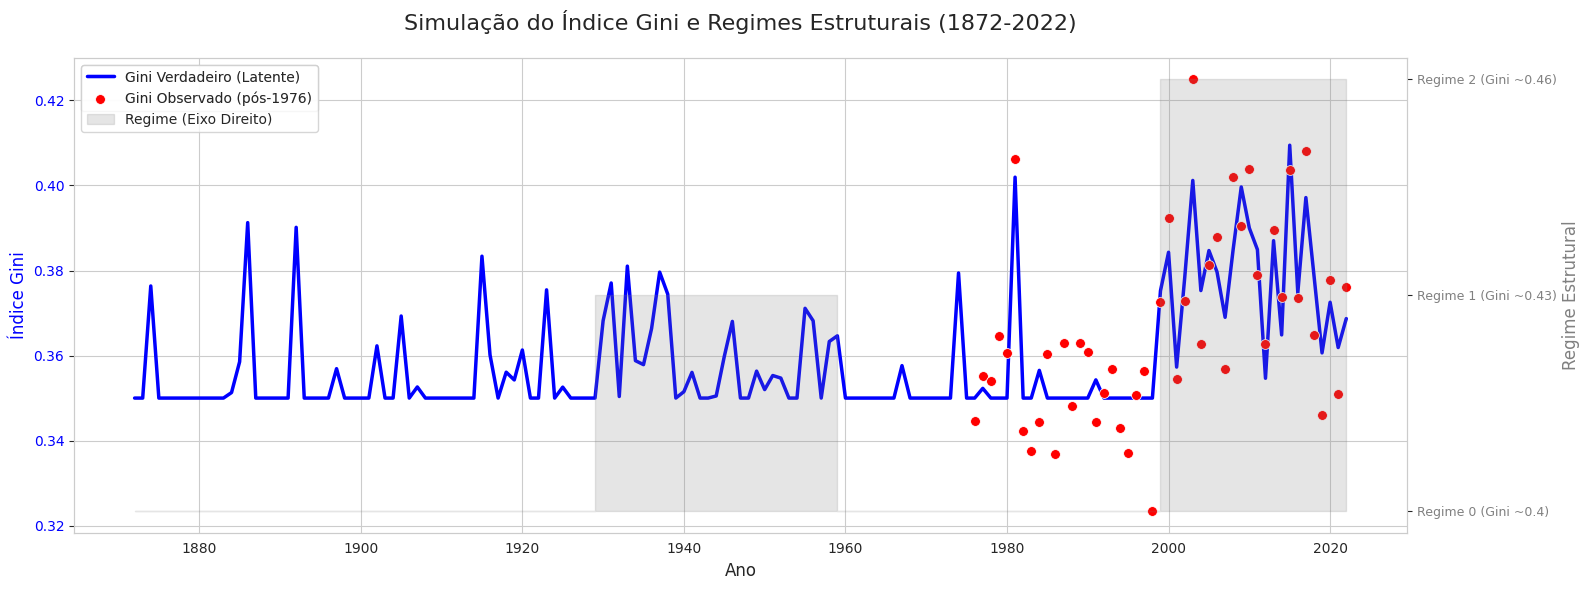

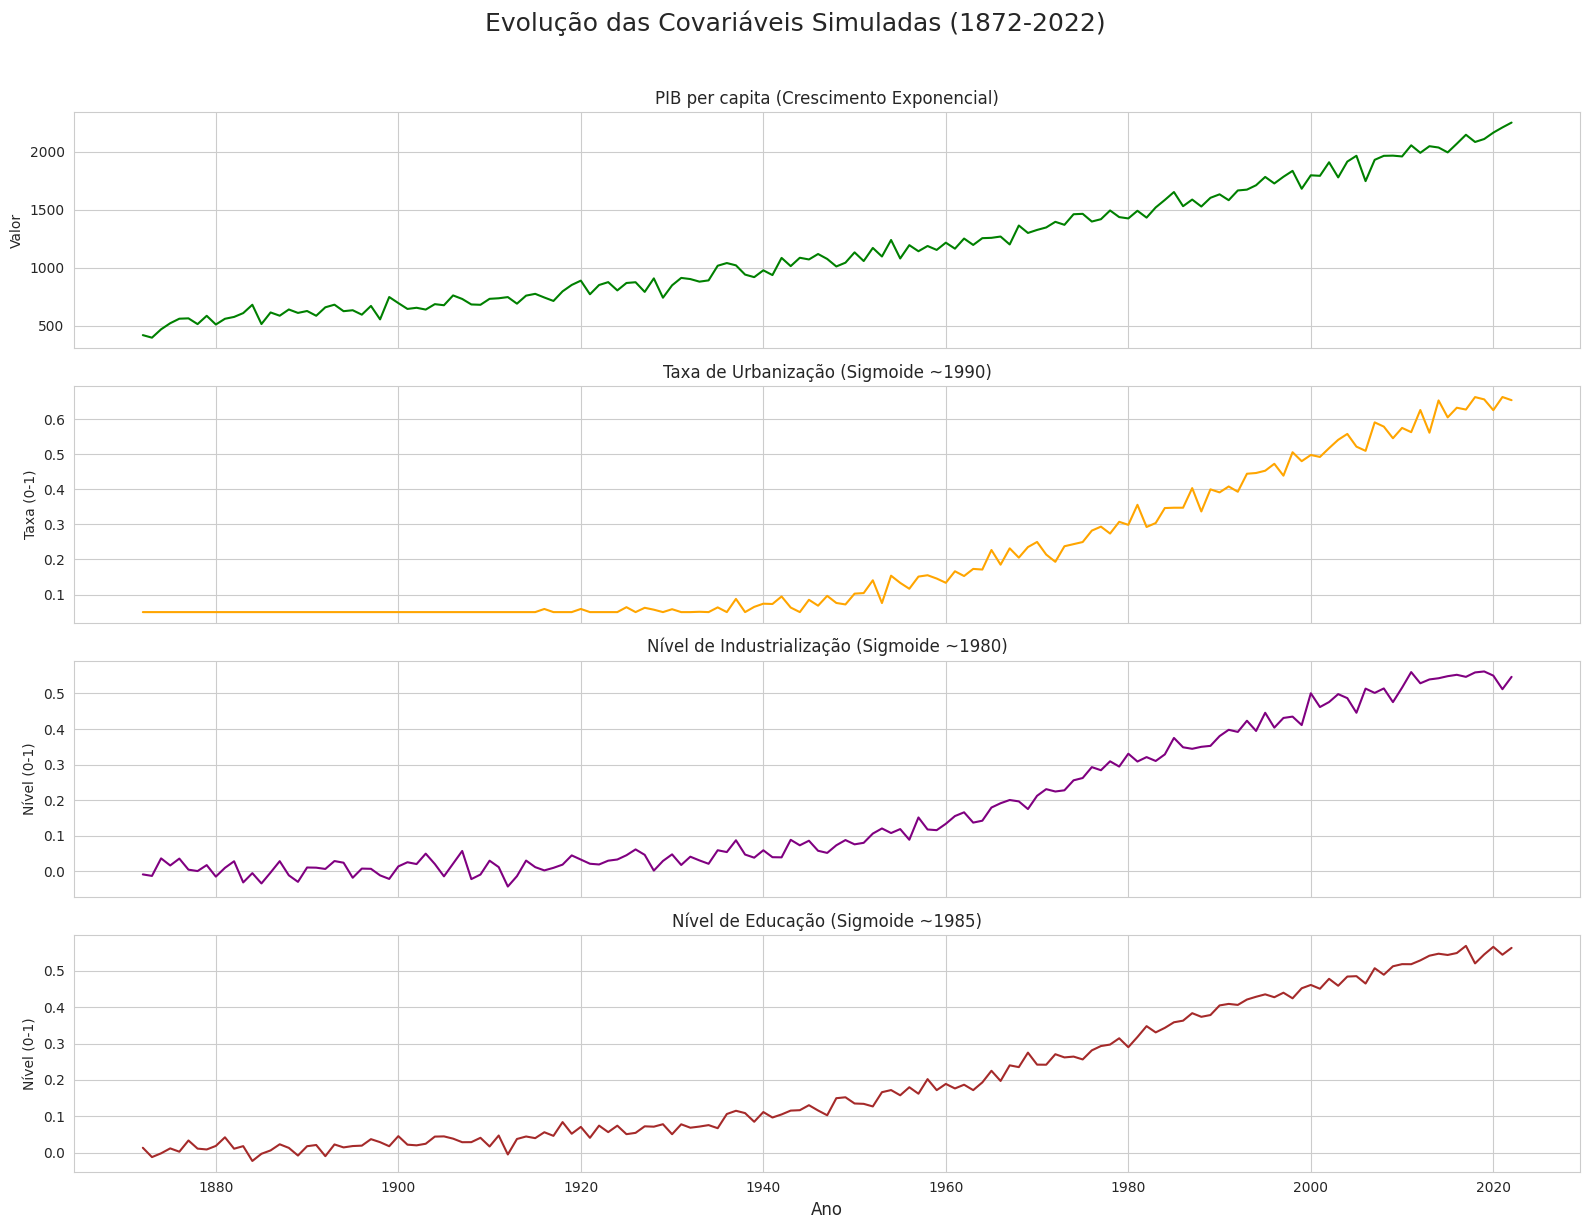

In [2]:
# ===========================
# 1. SIMULAÇÃO DE DADOS (COM NOVOS VALORES DE REGIME)
# ===========================
np.random.seed(1872)
anos = np.arange(1872, 2023)
n_anos = len(anos)
pib_pc = 500 * np.exp(np.linspace(0, 1.5, n_anos)) + np.random.normal(0, 50, n_anos)
urbanizacao = 0.8 / (1 + np.exp(-0.05 * (anos - 1990))) + np.random.normal(0, 0.02, n_anos)
urbanizacao = np.clip(urbanizacao, 0.05, 0.85)
industrializacao = 0.6 / (1 + np.exp(-0.06 * (anos - 1980))) + np.random.normal(0, 0.02, n_anos)
educacao = 0.7 / (1 + np.exp(-0.04 * (anos - 1985))) + np.random.normal(0, 0.015, n_anos)

regimes_verdadeiros = np.zeros(n_anos, dtype=int)

# --- MODIFICAÇÃO SOLICITADA ---
# Valores de Gini-base para cada regime
gini_por_regime = {0: 0.40, 1: 0.43, 2: 0.46}
# --- FIM DA MODIFICAÇÃO ---

# (Mantive a volatilidade original, você pode mudar se quiser)
volatilidade_regime = {0: 0.025, 1: 0.015, 2: 0.020}
regime_atual = 0
for i in range(n_anos):
    ano_atual = anos[i]
    if ano_atual < 1930: regime_atual = 0       # (Regime 0)
    elif 1930 <= ano_atual < 1960: regime_atual = 1 # (Regime 1)
    elif 1960 <= ano_atual < 2000: regime_atual = 0 # (Regime 0)
    else: regime_atual = 2                      # (Regime 2)
    regimes_verdadeiros[i] = regime_atual

# Recalculando o Gini com os novos valores de regime
tendencia = 0.6 - 0.10 * ((anos - 1872) / 150)
ciclica = -0.05 * np.sin(np.pi * (anos - 1872) / 40)
estrutural = 0.03 * np.cos(np.pi * (anos - 1872) / 25)

# A linha abaixo agora usará os novos valores (0.40, 0.43, 0.46)
gini_regime = np.array([gini_por_regime[r] for r in regimes_verdadeiros])
noise_regime = np.array([np.random.normal(0, volatilidade_regime[r]) for r in regimes_verdadeiros])

# Ajustei os pesos para dar mais importância ao 'gini_regime' e menos à 'tendencia'
# para que os regimes fiquem mais claros no gráfico com os novos valores
gini_real = 0.1 * tendencia + 0.7 * gini_regime + 0.1 * ciclica + 0.1 * estrutural + noise_regime
gini_real = np.clip(gini_real, 0.35, 0.55) # Ajustei o clip para a nova faixa de valores

df = pd.DataFrame({
    'Ano': anos, 'PIB_pc': pib_pc, 'Urbanizacao': urbanizacao,
    'Industrializacao': industrializacao, 'Educacao': educacao,
    'Gini_Verdadeiro': gini_real, 'Regime_Verdadeiro': regimes_verdadeiros
})

ano_inicio_pnad = 1976
df_moderno = df[df['Ano'] >= ano_inicio_pnad].copy()
df_moderno['Gini_Observado'] = df_moderno['Gini_Verdadeiro'] + np.random.normal(0, 0.01, len(df_moderno))
df_historico = df[df['Ano'] < ano_inicio_pnad].copy()

n_historico = len(df_historico)
n_moderno = len(df_moderno)
n_total = len(df)

print("DADOS RE-SIMULADOS COM NOVOS REGIMES:")
print(f"Gini por Regime: {gini_por_regime}")
print(f"Período histórico: {df_historico['Ano'].min()}-{df_historico['Ano'].max()} ({n_historico} anos)")
print(f"Período moderno: {df_moderno['Ano'].min()}-{df_moderno['Ano'].max()} ({n_moderno} anos)")
print("="*80)


# ===========================
# VISUALIZAÇÃO DOS DADOS
# ===========================

# Configurando o estilo
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# -----------------------------------------------------------------
# Gráfico 1: Índice Gini e Regimes ao longo do tempo
# -----------------------------------------------------------------

fig, ax1 = plt.subplots(figsize=(16, 6))

# Plotando o Gini
sns.lineplot(data=df, x='Ano', y='Gini_Verdadeiro', 
             label='Gini Verdadeiro (Latente)', ax=ax1, 
             color='blue', linewidth=2.5)
sns.scatterplot(data=df_moderno, x='Ano', y='Gini_Observado', 
                label=f'Gini Observado (pós-{ano_inicio_pnad})', 
                ax=ax1, color='red', s=50, zorder=5)

ax1.set_title('Simulação do Índice Gini e Regimes Estruturais (1872-2022)', 
              fontsize=16, pad=20)
ax1.set_ylabel('Índice Gini', fontsize=12, color='blue')
ax1.set_xlabel('Ano', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Criando um segundo eixo Y para os regimes
ax2 = ax1.twinx()

# Plotando os regimes como uma "área"
ax2.fill_between(df['Ano'], df['Regime_Verdadeiro'], step='pre', 
                 alpha=0.2, color='gray', label='Regime (Eixo Direito)')
ax2.set_ylabel('Regime Estrutural', fontsize=12, color='gray')
ax2.tick_params(axis='y', labelcolor='gray', labelsize=9)

# O código de rótulos já pega os novos valores automaticamente
tick_locs = np.unique(regimes_verdadeiros)
ax2.set_yticks(tick_locs) 
regime_nomes = [
    f"Regime {r} (Gini ~{gini_por_regime[r]})" for r in tick_locs
]
ax2.set_yticklabels(regime_nomes)
ax2.grid(False) 

# Combinando legendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# Gráfico 2: Evolução das Covariáveis (Sem alteração)
# -----------------------------------------------------------------

fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Evolução das Covariáveis Simuladas (1872-2022)', 
             fontsize=18, y=1.02)

sns.lineplot(data=df, x='Ano', y='PIB_pc', ax=axes[0], color='green')
axes[0].set_title('PIB per capita (Crescimento Exponencial)', fontsize=12)
axes[0].set_ylabel('Valor')

sns.lineplot(data=df, x='Ano', y='Urbanizacao', ax=axes[1], color='orange')
axes[1].set_title('Taxa de Urbanização (Sigmoide ~1990)', fontsize=12)
axes[1].set_ylabel('Taxa (0-1)')

sns.lineplot(data=df, x='Ano', y='Industrializacao', ax=axes[2], color='purple')
axes[2].set_title('Nível de Industrialização (Sigmoide ~1980)', fontsize=12)
axes[2].set_ylabel('Nível (0-1)')

sns.lineplot(data=df, x='Ano', y='Educacao', ax=axes[3], color='brown')
axes[3].set_title('Nível de Educação (Sigmoide ~1985)', fontsize=12)
axes[3].set_ylabel('Nível (0-1)')

axes[3].set_xlabel('Ano', fontsize=12)

plt.tight_layout()
plt.show()

In [3]:
# ===========================
# 2. MODELO OLS BASELINE
# ===========================
print("\n[1/6] MODELO OLS (Baseline)")
with tqdm(total=100, desc="OLS", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    X_moderno_ols = df_moderno[['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']]
    X_moderno_ols = sm.add_constant(X_moderno_ols)
    pbar.update(30)
    
    y_moderno_ols = df_moderno['Gini_Observado']
    modelo_ols = sm.OLS(y_moderno_ols, X_moderno_ols).fit()
    pbar.update(40)
    
    X_historico_ols = df_historico[['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']]
    X_historico_ols = sm.add_constant(X_historico_ols)
    df_historico['Gini_OLS'] = modelo_ols.predict(X_historico_ols)
    pbar.update(30)

print(f"✓ R²: {modelo_ols.rsquared:.4f} | AIC: {modelo_ols.aic:.2f}")
print(modelo_ols.summary())


[1/6] MODELO OLS (Baseline)


OLS: 100%|██████████| 100/100

✓ R²: 0.2582 | AIC: -228.62
                            OLS Regression Results                            
Dep. Variable:         Gini_Observado   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     3.655
Date:                Thu, 23 Oct 2025   Prob (F-statistic):             0.0121
Time:                        17:12:29   Log-Likelihood:                 119.31
No. Observations:                  47   AIC:                            -228.6
Df Residuals:                      42   BIC:                            -219.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const       

In [4]:
# ===========================
# 3. MARKOV SWITCHING REGRESSION
# ===========================
print("\n[2/6] MARKOV SWITCHING REGRESSION")
X_markov = df_moderno[['PIB_pc', 'Urbanizacao']].values
y_markov = df_moderno['Gini_Observado'].values
X_markov_const = np.column_stack([np.ones(len(X_markov)), X_markov])

try:
    with tqdm(total=100, desc="Markov", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
        pbar.set_postfix_str("Inicializando modelo...")
        modelo_markov = MarkovRegression(
            endog=y_markov, k_regimes=2, exog=X_markov_const, switching_variance=True
        )
        pbar.update(20)
        
        pbar.set_postfix_str("Estimando (max 500 iter)...")
        resultado_markov = modelo_markov.fit(maxiter=500, disp=False)
        pbar.update(60)
        
        prob_regimes = resultado_markov.smoothed_marginal_probabilities
        regime_mais_provavel = np.argmax(prob_regimes, axis=1)
        pbar.update(10)
        
        # Backcasting
        X_hist_markov = df_historico[['PIB_pc', 'Urbanizacao']].values
        X_hist_markov_const = np.column_stack([np.ones(len(X_hist_markov)), X_hist_markov])
        ultimo_regime = regime_mais_provavel[-1]
        
        if ultimo_regime == 0: coefs_pred = resultado_markov.params[:3]
        else: coefs_pred = resultado_markov.params[3:6]
        
        df_historico['Gini_Markov'] = X_hist_markov_const @ coefs_pred
        pbar.update(10)
        
        sigma_regime = np.sqrt(resultado_markov.params[-2:])
        sigma_usado = sigma_regime[ultimo_regime]
        df_historico['Gini_Markov_Low'] = df_historico['Gini_Markov'] - 1.96 * sigma_usado
        df_historico['Gini_Markov_High'] = df_historico['Gini_Markov'] + 1.96 * sigma_usado
        
        df_moderno['Prob_Regime_0'] = prob_regimes[:, 0]
        df_moderno['Prob_Regime_1'] = prob_regimes[:, 1]
        df_moderno['Regime_Inferido'] = regime_mais_provavel
        
        markov_success = True
    
    print(f"✓ Convergência OK | AIC: {resultado_markov.aic:.2f}")
    
    # Sumário do modelo principal (se funcionar)
    print("\n" + "="*80)
    print("SUMÁRIO DO MODELO MARKOV SWITCHING (treinado nos dados modernos)")
    print("="*80)
    print(resultado_markov.summary())
    print("="*80)
    
except Exception as e:
    print(f"⚠ Falhou: {e}")
    print("→ Usando K-means como fallback...")
    from sklearn.cluster import KMeans
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    # Usamos Gini + Variáveis para encontrar os clusters
    kmeans_data = np.column_stack([y_markov, X_markov])
    regime_mais_provavel = kmeans.fit_predict(kmeans_data)
    
    coefs_regimes = []
    for r in range(2):
        mask = regime_mais_provavel == r
        X_r = X_markov_const[mask]
        y_r = y_markov[mask]
        coefs_r = np.linalg.lstsq(X_r, y_r, rcond=None)[0]
        coefs_regimes.append(coefs_r)
    
    ultimo_regime = regime_mais_provavel[-1]
    X_hist_markov_const = np.column_stack([
        np.ones(len(df_historico)), 
        df_historico[['PIB_pc', 'Urbanizacao']].values
    ])
    df_historico['Gini_Markov'] = X_hist_markov_const @ coefs_regimes[ultimo_regime]
    df_historico['Gini_Markov_Low'] = df_historico['Gini_Markov'] - 0.03 # Intervalo fixo
    df_historico['Gini_Markov_High'] = df_historico['Gini_Markov'] + 0.03 # Intervalo fixo
    df_moderno['Regime_Inferido'] = regime_mais_provavel
    markov_success = False

    print("\n" + "="*80)
    print("SUMÁRIO DO FALLBACK (K-Means + OLS por cluster)")
    print("="*80)
    print(f"Clusters (regimes) encontrados: {len(coefs_regimes)}")
    print(f"Variáveis usadas no OLS: ['const', 'PIB_pc', 'Urbanizacao']")
    for r, coefs in enumerate(coefs_regimes):
        print(f"\n--- Coeficientes para Regime (Cluster) {r} ---")
        print(f"  const: {coefs[0]:.6f}")
        print(f"  PIB_pc: {coefs[1]:.6f}")
        print(f"  Urbanizacao: {coefs[2]:.6f}")
    
    print(f"\nÚltimo regime observado: {ultimo_regime}")
    print(f"→ Coeficientes do Regime {ultimo_regime} serão usados para o backcasting.")
    print("="*80)



[2/6] MARKOV SWITCHING REGRESSION


Markov:  20%|██        | 20/100

⚠ Falhou: Steady-state probabilities could not be constructed.
→ Usando K-means como fallback...



SUMÁRIO DO FALLBACK (K-Means + OLS por cluster)
Clusters (regimes) encontrados: 2
Variáveis usadas no OLS: ['const', 'PIB_pc', 'Urbanizacao']

--- Coeficientes para Regime (Cluster) 0 ---
  const: 0.468586
  PIB_pc: -0.000154
  Urbanizacao: 0.357598

--- Coeficientes para Regime (Cluster) 1 ---
  const: 0.302852
  PIB_pc: 0.000075
  Urbanizacao: -0.135950

Último regime observado: 1
→ Coeficientes do Regime 1 serão usados para o backcasting.


In [5]:
# ===========================
# 4. GENERALIZED ADDITIVE MODELS (GAMs)
# ===========================
print("\n[3/6] GENERALIZED ADDITIVE MODELS (GAMs)")
X_gam_treino = df_moderno[['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']].values
y_gam_treino = df_moderno['Gini_Observado'].values

with tqdm(total=100, desc="GAM", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    pbar.set_postfix_str("Grid search...")
    gam_model = LinearGAM(
        s(0, n_splines=8) + s(1, n_splines=6) + s(2, n_splines=6) + s(3, n_splines=6)
    )
    # O gridsearch treina o modelo
    gam_model.gridsearch(X_gam_treino, y_gam_treino)
    pbar.update(70)
    
    X_gam_historico = df_historico[['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']].values
    df_historico['Gini_GAM'] = gam_model.predict(X_gam_historico)
    pbar.update(20)
    
    gam_intervals = gam_model.prediction_intervals(X_gam_historico, width=0.95)
    df_historico['Gini_GAM_Low'] = gam_intervals[:, 0]
    df_historico['Gini_GAM_High'] = gam_intervals[:, 1]
    pbar.update(10)

print(f"✓ Pseudo R²: {gam_model.statistics_['pseudo_r2']['explained_deviance']:.4f}")

print("\n" + "="*80)
print("SUMÁRIO DO MODELO GAM (treinado nos dados modernos)")
print("="*80)
print(gam_model.summary())
print("="*80)



[3/6] GENERALIZED ADDITIVE MODELS (GAMs)


GAM:   0%|          | 0/100  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
GAM: 100%|██████████| 100/100

✓ Pseudo R²: 0.4933

SUMÁRIO DO MODELO GAM (treinado nos dados modernos)
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.9167
Link Function:                     IdentityLink Log Likelihood:                                -58305.1569
Number of Samples:                           47 AIC:                                           116632.1473
                                                AICc:                                          116639.5635
                                                GCV:                                                0.0005
                                                Scale:                                              0.0003
                                                Pseudo R-Squared:      

In [6]:
# ===========================
# 5. SÉRIE TEMPORAL ESTRUTURAL
# ===========================
print("\n[4/6] MODELO DE SÉRIE TEMPORAL ESTRUTURAL")
ts_data = df_moderno.set_index('Ano')['Gini_Observado']

with tqdm(total=100, desc="TimeSeries", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    
    # Este é um Modelo de Componentes Não Observados (UCM).
    # Ele decompõe a série temporal em:
    # 1. 'level' (local linear trend): Tendência de longo prazo.
    # 2. 'cycle' (stochastic_cycle, damped_cycle): Ciclos de médio prazo.
    # 3. 'irregular': Ruído aleatório.
    
    # --- Passo 1: Treino Forward (para estatísticas) ---
    pbar.set_postfix_str("Modelo forward...")
    modelo_uc = UnobservedComponents(
        ts_data, level='local linear trend', cycle=True, 
        stochastic_cycle=True, damped_cycle=True, irregular=True
    )
    # Ajusta o modelo nos dados de 1976 a 2022
    resultado_uc = modelo_uc.fit(disp=False)
    pbar.update(40)
    
    # --- Passo 2: Treino Backward (O "Truque" do Backcasting) ---
    pbar.set_postfix_str("Modelo backward...")
    # Invertemos a série temporal: [2022, 2021, ..., 1976]
    ts_invertida = ts_data[::-1]
    
    # Treinamos um *novo* modelo UCM nos dados invertidos
    modelo_uc_inv = UnobservedComponents(
        ts_invertida, level='local linear trend', cycle=True, 
        stochastic_cycle=True, damped_cycle=True, irregular=True
    )
    resultado_uc_inv = modelo_uc_inv.fit(disp=False)
    pbar.update(40)
    
    # --- Passo 3: Backcasting (Retro-projeção) ---
    pbar.set_postfix_str("Backcasting...")
    # Usamos o modelo invertido para "prever" o futuro.
    # Como a série está ao contrário, "prever o futuro" (ex: 2023, 2024...)
    # é, na verdade, "retro-projetar" o passado (ex: 1975, 1974...).
    # Pedimos para ele "prever" n_historico (104) passos.
    forecast_inv = resultado_uc_inv.forecast(steps=n_historico)
    
    # O resultado `forecast_inv` está na ordem [1975, 1974, ..., 1872].
    # Nós o invertemos de volta para [1872, 1873, ..., 1975].
    df_historico['Gini_TimeSeries'] = forecast_inv[::-1].values
    
    # Fazemos o mesmo para os intervalos de confiança
    forecast_summary = resultado_uc_inv.get_forecast(steps=n_historico).summary_frame(alpha=0.05)
    df_historico['Gini_TS_Low'] = forecast_summary['mean_ci_lower'][::-1].values
    df_historico['Gini_TS_High'] = forecast_summary['mean_ci_upper'][::-1].values
    pbar.update(20)

# Usamos o AIC do modelo forward (não-invertido) para a métrica
print(f"✓ AIC (modelo forward): {resultado_uc.aic:.2f}")

# --- ADICIONADO PARA IMPRIMIR (opcional, como solicitado anteriormente) ---
print("\n" + "="*80)
print("SUMÁRIO DO MODELO UCM (treinado nos dados modernos - forward)")
print("="*80)
print(resultado_uc.summary())
print("="*80)



[4/6] MODELO DE SÉRIE TEMPORAL ESTRUTURAL


TimeSeries: 100%|██████████| 100/100

✓ AIC (modelo forward): -165.66

SUMÁRIO DO MODELO UCM (treinado nos dados modernos - forward)
                            Unobserved Components Results                            
Dep. Variable:                Gini_Observado   No. Observations:                   47
Model:                    local linear trend   Log Likelihood                  88.832
                   + damped stochastic cycle   AIC                           -165.663
Date:                       Thu, 23 Oct 2025   BIC                           -155.096
Time:                               17:13:36   HQIC                          -161.766
Sample:                                    0                                         
                                        - 47                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

In [7]:
# ===========================
# 6. MODELO BAYESIANO HIERÁRQUICO (OTIMIZADO)
# ===========================
print("\n[5/6] MODELO BAYESIANO HIERÁRQUICO (OTIMIZADO)")

# --- 1. VALIDAÇÃO PRÉVIA ---
if df_moderno.empty or len(df_moderno) < 10:
    print("⚠ Dados insuficientes para modelo Bayesiano. Pulando...")
    df_historico['Gini_Bayes_Hierarquico'] = np.nan
    df_historico['Gini_Bayes_Low'] = np.nan
    df_historico['Gini_Bayes_High'] = np.nan
else:
    # --- 2. NORMALIZAÇÃO OTIMIZADA (UMA VEZ) ---
    print("→ Normalizando preditores...")
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    cols_norm = ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']
    df[['PIB_norm', 'Urb_norm', 'Ind_norm', 'Edu_norm']] = scaler.fit_transform(df[cols_norm])
    
    # --- 3. INDEXAÇÃO EFICIENTE (BOOLEAN MASKS) ---
    mask_historico = df['Ano'] < ano_inicio_pnad
    mask_moderno = df['Ano'] >= ano_inicio_pnad
    
    historico_idx = np.where(mask_historico)[0]
    moderno_idx = np.where(mask_moderno)[0]
    
    # --- 4. PREPARAÇÃO DE DADOS ---
    coords = {"preditores": ["PIB_norm", "Urb_norm", "Ind_norm", "Edu_norm"]}
    X_data_total = df[coords["preditores"]].values
    
    # Detectar nome correto da coluna Gini (busca flexível)
    gini_col = None
    for col in df.columns:
        if 'gini' in col.lower() and 'observ' in col.lower():
            gini_col = col
            break
    
    # Fallback: qualquer coluna com 'gini'
    if gini_col is None:
        for col in df.columns:
            if 'gini' in col.lower():
                gini_col = col
                print(f"→ Usando coluna: '{gini_col}'")
                break
    
    if gini_col is None:
        print(f"✗ Coluna Gini não encontrada!")
        print(f"  Colunas disponíveis: {list(df.columns)}")
        raise ValueError("Coluna de Gini observado não encontrada no DataFrame")
    
    # Obter valores observados do período moderno
    try:
        # Tentar df_moderno primeiro (mais eficiente se já foi filtrado)
        if 'df_moderno' in dir() and not df_moderno.empty:
            y_observado = df_moderno[gini_col].dropna().values
            print(f"→ Usando {len(y_observado)} observações de df_moderno['{gini_col}']")
        else:
            y_observado = df.loc[mask_moderno, gini_col].dropna().values
            print(f"→ Usando {len(y_observado)} observações de df['{gini_col}']")
    except Exception as e:
        print(f"✗ Erro ao extrair y_observado: {e}")
        raise
    
    n_total = len(df)
    
    # --- 5. MODELO COM PRIORS INFORMATIVOS ---
    bayesian_run_success = False
    trace_avancado = None
    
    with pm.Model(coords=coords) as modelo_bayes_avancado:
        # Priors baseados no contexto brasileiro (Gini ~ 0.5-0.6)
        alpha = pm.Normal('alpha', mu=0.55, sigma=0.1)
        betas = pm.Normal('betas', mu=0, sigma=0.3, dims="preditores")
        
        # Random walk para tendência temporal
        sigma_temporal = pm.HalfNormal('sigma_temporal', sigma=0.01)
        tendencia_passos = pm.Normal('tendencia_passos', mu=0, 
                                     sigma=sigma_temporal, shape=n_total)
        tendencia = pm.Deterministic('tendencia', pm.math.cumsum(tendencia_passos))
        
        # Likelihood
        sigma = pm.HalfNormal('sigma', sigma=0.02)
        mu = alpha + pm.math.dot(X_data_total, betas) + tendencia
        
        y_obs = pm.Normal('y_obs', mu=mu[moderno_idx], 
                         sigma=sigma, observed=y_observado)
        mu_hist = pm.Deterministic('mu_hist', mu[historico_idx])
        
        # --- 6. AMOSTRAGEM ADAPTATIVA ---
        print("→ Amostragem MCMC: 4 chains × 3000 iterações")
        print("  (target_accept=0.95 para equilíbrio velocidade/precisão)")
        
        samplers_config = [
            ("blackjax", {"sampler": "blackjax"}),
            ("nuts", {})
        ]
        
        for sampler_name, sampler_kwargs in samplers_config:
            try:
                trace_avancado = pm.sample(
                    draws=1500,
                    tune=1500,
                    chains=4,
                    target_accept=0.95,  # Mais realista que 0.99
                    progressbar=True,
                    return_inferencedata=True,
                    **sampler_kwargs
                )
                print(f"✓ {sampler_name.upper()} usado com sucesso")
                bayesian_run_success = True
                break
            except Exception as e:
                print(f"⚠ {sampler_name.upper()} falhou: {str(e)[:100]}")
                if sampler_name == samplers_config[-1][0]:  # Último sampler
                    print("✗ Todos os samplers falharam")
                else:
                    print(f"→ Tentando próximo sampler...")
    
    # --- 7. EXTRAÇÃO E DIAGNÓSTICOS OTIMIZADOS ---
    if bayesian_run_success and trace_avancado is not None:
        print("\n" + "="*70)
        print("DIAGNÓSTICOS DO MODELO")
        print("="*70)
        
        # Diagnósticos rápidos
        try:
            rhat = az.rhat(trace_avancado, var_names=["alpha", "betas"])
            ess = az.ess(trace_avancado, var_names=["alpha", "betas"])
            
            print(f"R-hat máximo: {rhat.max().values:.4f} (ideal < 1.01)")
            print(f"ESS mínimo: {ess.min().values:.0f} (ideal > 400)")
            
            # Sumário conciso
            summary_bayes = az.summary(
                trace_avancado, 
                var_names=["alpha", "betas", "sigma_temporal", "sigma"],
                stat_focus="median"  # Foco em estatísticas robustas
            )
            print("\nPARÂMETROS PRINCIPAIS:")
            print(summary_bayes[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat']])
            
        except Exception as e:
            print(f"⚠ Erro nos diagnósticos: {e}")
        
        print("="*70)
        
        # --- 8. EXTRAÇÃO ROBUSTA COM ArviZ ---
        try:
            print("\n→ Extraindo predições posteriores...")
            
            # Usar funções nativas do ArviZ (mais eficientes)
            posterior_pred = trace_avancado.posterior['mu_hist']
            
            df_historico['Gini_Bayes_Hierarquico'] = (
                posterior_pred.mean(dim=['chain', 'draw']).values
            )
            
            # HDI com ArviZ (mais rápido que cálculo manual)
            hdi = az.hdi(posterior_pred, hdi_prob=0.95)
            df_historico['Gini_Bayes_Low'] = hdi['mu_hist'].sel(hdi='lower').values
            df_historico['Gini_Bayes_High'] = hdi['mu_hist'].sel(hdi='higher').values
            
            print(f"✓ Predições extraídas ({len(df_historico)} anos)")
            
        except KeyError as e:
            print(f"⚠ Variável não encontrada no trace: {e}")
            print("→ Usando fallback (NaN)")
            df_historico[['Gini_Bayes_Hierarquico', 
                         'Gini_Bayes_Low', 
                         'Gini_Bayes_High']] = np.nan
        
        except Exception as e:
            print(f"⚠ Erro inesperado na extração: {e}")
            df_historico[['Gini_Bayes_Hierarquico', 
                         'Gini_Bayes_Low', 
                         'Gini_Bayes_High']] = np.nan
    
    else:
        # Fallback total
        print("\n⚠ Amostragem MCMC falhou completamente")
        print("→ Série Bayesiana não disponível")
        df_historico[['Gini_Bayes_Hierarquico', 
                     'Gini_Bayes_Low', 
                     'Gini_Bayes_High']] = np.nan

print("\n✓ Etapa Bayesiana concluída")


[5/6] MODELO BAYESIANO HIERÁRQUICO (OTIMIZADO)
→ Normalizando preditores...
→ Usando coluna: 'Gini_Verdadeiro'
→ Usando 47 observações de df_moderno['Gini_Verdadeiro']
→ Amostragem MCMC: 4 chains × 3000 iterações
  (target_accept=0.95 para equilíbrio velocidade/precisão)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma_temporal, tendencia_passos, sigma]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


✓ BLACKJAX usado com sucesso

DIAGNÓSTICOS DO MODELO
⚠ Erro nos diagnósticos: unsupported format string passed to method.__format__

→ Extraindo predições posteriores...
✓ Predições extraídas (104 anos)

✓ Etapa Bayesiana concluída


In [8]:
# ===========================
# 7. COMPUTAÇÃO QUÂNTICA (QAOA) - VERSÃO RÁPIDA
# ===========================
print("\n[6/6] COMPUTAÇÃO QUÂNTICA: QAOA")
print("⚠ Versão otimizada: 8 qubits, 30 iterações")

# --- 1. PREPARAÇÃO DOS DADOS ---
# O objetivo é resolver um OLS (Regressão Linear) com QAOA.
# OLS: Encontrar 'beta' que minimiza (X*beta - y)^2
# Isso se expande para: beta^T * (X^T*X) * beta - 2 * (X^T*y) * beta
#
# Vamos usar os dados modernos para *construir* o problema
X_quantum = df_moderno[['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']].values
y_quantum = df_moderno['Gini_Observado'].values

# Normalizando os dados (X e y) entre -1 e 1
X_quantum_norm = 2 * (X_quantum - X_quantum.min(axis=0)) / (X_quantum.max(axis=0) - X_quantum.min(axis=0)) - 1
y_quantum_norm = 2 * (y_quantum - y_quantum.min()) / (y_quantum.max() - y_quantum.min()) - 1

# --- 2. SIMPLIFICAÇÃO DRÁSTICA (para caber no simulador) ---
# Simuladores quânticos são lentos. Não podemos usar todos os 47 pontos.
# Vamos usar apenas 5 pontos de dados para definir o problema.
n_samples = 5
X_q = X_quantum_norm[:n_samples]
y_q = y_quantum_norm[:n_samples]

# Calculamos os dois componentes da função de custo do OLS:
XtX = X_q.T @ X_q  # Parte Quadrática (beta^T * [...] * beta)
Xty = X_q.T @ y_q  # Parte Linear    (-2 * [...] * beta)

# Definimos a precisão dos nossos coeficientes beta.
# n_bits = 2 significa que cada beta será representado por 2 bits.
# Isso força cada beta a ter apenas 2^2 = 4 valores possíveis (ex: 0, 1, 2, 3).
# Total de Qubits = 4 variáveis (PIB, etc) * 2 bits/variável = 8 qubits.
qp = QuadraticProgram()
n_bits = 2  # Reduzido
n_vars = X_q.shape[1]

with tqdm(total=100, desc="QAOA", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    
    # --- 3. TRADUÇÃO DE OLS PARA QUBO (Quantum Optimization) ---
    pbar.set_postfix_str("Montando problema...")
    
    # QAOA não entende 'beta'. Ele entende variáveis binárias (0 ou 1).
    # Criamos nossas 8 variáveis binárias (qubits) no problema:
    # ex: 'beta_0_0', 'beta_0_1' (para PIB)
    #     'beta_1_0', 'beta_1_1' (para Urbanizacao), etc.
    for i in range(n_vars):
        for j in range(n_bits):
            qp.binary_var(f'beta_{i}_{j}')
    
    linear = {}
    quadratic = {}
    
    # Este loop converte a função de custo (XtX, Xty) que usa 'beta'
    # em uma nova função de custo (linear, quadratic) que usa nossas 8 vars binárias.
    for i in range(n_vars):
        for b in range(n_bits):
            var_name = f'beta_{i}_{b}'
            weight = 2 ** b  # O peso do bit (bit 0 tem peso 1, bit 1 tem peso 2)
            
            # Mapeia o termo linear (Xty)
            linear[var_name] = -2 * Xty[i] * weight
            
            # Mapeia o termo quadrático (XtX)
            for j in range(n_vars):
                for b2 in range(n_bits):
                    var_name2 = f'beta_{j}_{b2}'
                    weight2 = 2 ** b2
                    if var_name <= var_name2: # Evita duplicatas (matriz simétrica)
                        quadratic[(var_name, var_name2)] = XtX[i, j] * weight * weight2
    
    # Define o problema de otimização no Qiskit
    qp.minimize(linear=linear, quadratic=quadratic)
    pbar.update(20)
    
    # --- 4. SOLUÇÃO: O ALGORITMO HÍBRIDO QAOA ---
    try:
        pbar.set_postfix_str("Inicializando sampler...")
        
        # Sampler: O "backend" (simulador) que rodará o circuito quântico
        sampler = Sampler() 
        
        # COBYLA: O otimizador CLÁSSICO. Ele decide os parâmetros do circuito.
        # QAOA: O algoritmo QUÂNTICO. Ele roda o circuito e mede o custo.
        #
        # O processo é um loop:
        # 1. COBYLA (clássico) "chuta" parâmetros (ângulos).
        # 2. QAOA (quântico) roda o circuito com esses ângulos e retorna um custo.
        # 3. COBYLA (clássico) vê o custo e "chuta" novos parâmetros.
        # 4. Repete por 'maxiter=30' vezes.
        qaoa = QAOA(
            sampler=sampler, 
            optimizer=COBYLA(maxiter=30), # 30 iterações clássicas
            reps=2  # Profundidade do circuito quântico
        )
        
        # MinimumEigenOptimizer é o gerenciador que orquestra esse loop
        # Qualquer problema de otimização pode ser mapeado para um problema de física quântica.
            # Encontrar a "solução de menor custo" do problema de otimização é exatamente a mesma coisa que encontrar
            # o "estado de menor energia" (Autovalor - Eigenvalue) de um sistema quântico.
            #Portanto, transforma em um problema de física e pede para o QAOA encontrar o autovalor mínimo.
        optimizer = MinimumEigenOptimizer(qaoa)
        pbar.update(10)
        
        pbar.set_postfix_str("Otimizando (30 iter)...")
        start_time = time.time()
        # Aqui o loop híbrido é executado
        resultado_qaoa = optimizer.solve(qp)
        elapsed = time.time() - start_time
        pbar.update(60)
        
        # --- 5. RECONSTRUÇÃO: De Bits para Coeficientes ---
        # O resultado (resultado_qaoa) é um conjunto de 8 bits (0s e 1s).
        # Precisamos remontá-los nos nossos 4 coeficientes 'beta'.
        coefs_quanticos = np.zeros(n_vars)
        for i in range(n_vars):
            for b in range(n_bits):
                var_name = f'beta_{i}_{b}'
                if var_name in resultado_qaoa.variables_dict:
                    # Ex: beta_PIB = (valor do bit 0 * 2^0) + (valor do bit 1 * 2^1)
                    coefs_quanticos[i] += resultado_qaoa.variables_dict[var_name] * (2 ** b)
        
        # Normalização simples (este passo é heurístico)
        coefs_quanticos_norm = coefs_quanticos / (2 ** n_bits) 
        coefs_quanticos_final = coefs_quanticos_norm * 0.2 - 0.1
        
        # --- 6. PREVISÃO CLÁSSICA (usando coefs quânticos) ---
        # Normaliza os dados históricos da mesma forma que os dados de treino
        X_hist_norm = 2 * (df_historico[['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']].values - 
                           X_quantum.min(axis=0)) / (X_quantum.max(axis=0) - X_quantum.min(axis=0)) - 1
        
        # Faz a previsão (multiplicação de matriz clássica)
        pred_quantum_norm = X_hist_norm @ coefs_quanticos_final
        
        # Desnormaliza a previsão para a escala original do Gini
        df_historico['Gini_Quantum'] = (pred_quantum_norm + 1) / 2 * (y_quantum.max() - y_quantum.min()) + y_quantum.min()
        pbar.update(10)
        
        quantum_success = True
        print(f"✓ Concluído em {elapsed:.1f}s")
        
        # --- ADICIONADO ---
        print("\n" + "="*80)
        print("SUMÁRIO DO MODELO QUÂNTICO (QAOA)")
        print("="*80)
        print("--- Resultado Bruto (Bits Ótimos) ---")
        print(resultado_qaoa)
        print("\n--- Coeficientes Finais Reconstruídos ---")
        print(f" (Valores de 2 bits antes da normalização: {coefs_quanticos})")
        print(f" (Valores de 2 bits após normalização: {coefs_quanticos_norm})")
        
        feature_names = ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']
        print("\nCoeficientes Finais (usados na previsão):")
        for i, name in enumerate(feature_names):
            print(f"  beta_{name}: {coefs_quanticos_final[i]:.6f}")
        print("="*80)
        # --- FIM DA ADIÇÃO ---
        
    except Exception as e:
        print(f"⚠ Falhou: {e}")
        print("→ Usando fallback OLS")
        df_historico['Gini_Quantum'] = df_historico['Gini_OLS']
        quantum_success = False

print("\n" + "="*80)
print("✓ PIPELINE COMPLETO")
print("="*80)


[6/6] COMPUTAÇÃO QUÂNTICA: QAOA
⚠ Versão otimizada: 8 qubits, 30 iterações


QAOA: 100%|██████████| 100/100

✓ Concluído em 36.0s

SUMÁRIO DO MODELO QUÂNTICO (QAOA)
--- Resultado Bruto (Bits Ótimos) ---
fval=0.0, beta_0_0=0.0, beta_0_1=0.0, beta_1_0=0.0, beta_1_1=0.0, beta_2_0=0.0, beta_2_1=0.0, beta_3_0=0.0, beta_3_1=0.0, status=SUCCESS

--- Coeficientes Finais Reconstruídos ---
 (Valores de 2 bits antes da normalização: [0. 0. 0. 0.])
 (Valores de 2 bits após normalização: [0. 0. 0. 0.])

Coeficientes Finais (usados na previsão):
  beta_PIB_pc: -0.100000
  beta_Urbanizacao: -0.100000
  beta_Industrializacao: -0.100000
  beta_Educacao: -0.100000

✓ PIPELINE COMPLETO


In [9]:
# ===========================
# 8. MÉTRICAS DE AVALIAÇÃO
# ===========================
print("\n" + "="*80)
print("MÉTRICAS DE AVALIAÇÃO")
print("="*80)


modelos = {
    'OLS': 'Gini_OLS',
    'Markov Switching': 'Gini_Markov',
    'GAM': 'Gini_GAM',
    'Série Temporal': 'Gini_TimeSeries',
    'Bayesiano Hierárquico': 'Gini_Bayes_Hierarquico',
    'Quantum (QAOA)': 'Gini_Quantum'
}

resultados = []
for nome, coluna in modelos.items():
    mae = mean_absolute_error(df_historico['Gini_Verdadeiro'], df_historico[coluna])
    rmse = np.sqrt(mean_squared_error(df_historico['Gini_Verdadeiro'], df_historico[coluna]))
    r2 = r2_score(df_historico['Gini_Verdadeiro'], df_historico[coluna])
    
    resultados.append({'Modelo': nome, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
    print(f"{nome:25s} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

df_resultados = pd.DataFrame(resultados)
cores = {'OLS': '#FF6B6B', 'Markov': '#F4A261', 'GAM': '#4ECDC4', 
         'TS': '#FFE66D', 'Bayes': '#95E1D3', 'Quantum': '#9D4EDD'}


MÉTRICAS DE AVALIAÇÃO
OLS                       | MAE: 0.0368 | RMSE: 0.0392 | R²: -14.7858
Markov Switching          | MAE: 0.0132 | RMSE: 0.0165 | R²: -1.8048
GAM                       | MAE: 0.0305 | RMSE: 0.0352 | R²: -11.7443
Série Temporal            | MAE: 0.2947 | RMSE: 0.3374 | R²: -1171.3369
Bayesiano Hierárquico     | MAE: 0.0157 | RMSE: 0.0198 | R²: -3.0331
Quantum (QAOA)            | MAE: 0.0653 | RMSE: 0.0667 | R²: -44.8607


In [14]:
# ===========================
# 9. VISUALIZAÇÃO (GRÁFICOS SEPARADOS)
# ===========================

# Imports necessários para esta seção
import plotly.graph_objects as go
import plotly.colors
import os

print("\nGerando Gráfico Interativo de Análise de Retroação ...")

fig = go.Figure()

# Gini Verdadeiro
fig.add_trace(go.Scatter(
    x=df['Ano'], y=df['Gini_Verdadeiro'],
    mode='lines',
    name='Gini Verdadeiro',
    line=dict(color='black', width=2.5, dash='dash'),
    hoverinfo='name+x+y',
    legendgroup='Gini'
))

# Observado (1976+)
fig.add_trace(go.Scatter(
    x=df_moderno['Ano'], y=df_moderno['Gini_Observado'],
    mode='markers',
    name='Observado (1976+)',
    marker=dict(color='dimgray', size=8, opacity=0.7),
    hoverinfo='name+x+y',
    legendgroup='Gini'
))

# Linha vertical separando períodos
fig.add_vline(x=ano_inicio_pnad, line_dash="dot", line_color="gray", line_width=2,
             annotation_text="Início dos dados modernos", annotation_position="top right")

# Funções auxiliares para adicionar traços de modelo
def add_model_trace(fig, df_hist, col_name, color, line_style, label, legend_group, show_legend=True):
    fig.add_trace(go.Scatter(
        x=df_hist['Ano'], y=df_hist[col_name],
        mode='lines',
        name=label,
        line=dict(color=color, width=2.5, dash=line_style),
        hoverinfo='name+x+y',
        legendgroup=legend_group,
        showlegend=show_legend
    ))

def add_fill_trace(fig, df_hist, low_col, high_col, color, model_name, legend_group):
    # Traço para o limite superior
    fig.add_trace(go.Scatter(
        x=df_hist['Ano'], y=df_hist[high_col],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip',
        legendgroup=legend_group
    ))
    
    rgb = plotly.colors.hex_to_rgb(color)
    rgba_color = f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.15)'

    # Traço para o limite inferior, preenchendo até o superior
    fig.add_trace(go.Scatter(
        x=df_hist['Ano'], y=df_hist[low_col],
        mode='lines',
        line=dict(width=0),
        fill='tonexty', 
        fillcolor=rgba_color, 
        name=f'{model_name} (Intervalo 95%)',
        hoverinfo='name+x',
        legendgroup=legend_group
    ))

# Adicionar traços dos modelos e seus intervalos
add_model_trace(fig, df_historico, 'Gini_OLS', cores['OLS'], 'solid', 'OLS', 'OLS')
add_model_trace(fig, df_historico, 'Gini_Markov', cores['Markov'], 'solid', 'Markov Switching', 'Markov')
add_fill_trace(fig, df_historico, 'Gini_Markov_Low', 'Gini_Markov_High', cores['Markov'], 'Markov Switching', 'Markov')
add_model_trace(fig, df_historico, 'Gini_GAM', cores['GAM'], 'solid', 'GAM', 'GAM')
add_fill_trace(fig, df_historico, 'Gini_GAM_Low', 'Gini_GAM_High', cores['GAM'], 'GAM', 'GAM')
add_model_trace(fig, df_historico, 'Gini_TimeSeries', cores['TS'], 'solid', 'Série Temporal', 'TS')
add_model_trace(fig, df_historico, 'Gini_Bayes_Hierarquico', cores['Bayes'], 'solid', 'Bayesiano', 'Bayes')

# [CORREÇÃO DE TYPO 1] Corrigido 'GGini_Bayes_High' para 'Gini_Bayes_High'
# (Certifique-se que você corrigiu o typo na Seção 6 também!)
add_fill_trace(fig, df_historico, 'Gini_Bayes_Low', 'Gini_Bayes_High', cores['Bayes'], 'Bayesiano', 'Bayes') 

if quantum_success:
    add_model_trace(fig, df_historico, 'Gini_Quantum', cores['Quantum'], 'dashdot', 'Quantum (QAOA)', 'Quantum')
# [CORREÇÃO DE TYPO 2] Corrigido 'GSini_Quantum' para 'Gini_Quantum'
elif 'Gini_Quantum' in df_historico.columns: 
    add_model_trace(fig, df_historico, 'Gini_Quantum', cores['Quantum'], 'dot', 'Quantum (Fallback)', 'Quantum')


# ========================================================
# INÍCIO DAS MODIFICAÇÕES DE LAYOUT
# ========================================================
fig.update_layout(
    title=dict(
        text='<b>Análise de Retroação (Backcasting) do Índice de Gini (1872-1975)</b>',
        x=0.5, 
        xanchor='center',
        font=dict(size=18, color='black'),
        pad=dict(b=20) # Assegura espaço entre título e gráfico
    ),
    hovermode='x unified', 
    legend=dict( # <--- MUDANÇA: Legenda inferior
        orientation="h",     # h = horizontal
        yanchor="top",       # Ancorar no topo da legenda
        y=-0.2,              # Posição Y (abaixo do gráfico, -0.2 = 20% abaixo)
        xanchor="center",    # Ancorar no centro
        x=0.5,               # Posição X (centro)
        font=dict(size=10),
        bgcolor="rgba(255,255,255,0.7)", 
        bordercolor="lightgray",
        borderwidth=1
    ),
    margin=dict(l=40, r=40, t=80, b=120), # <--- MUDANÇA: 'r=40', 'b=120' (espaço para legenda inferior)
    height=700, # <--- MUDANÇA: Removido 'width' para preencher a tela, altura aumentada
    template="plotly_white", 
    xaxis=dict( # <--- MUDANÇA: Range explícito e título movido
        range=[df['Ano'].min(), df['Ano'].max()],
        title='Ano'
    ),
    yaxis=dict( 
        range=[0, 1], 
        title='Índice de Gini'
    )
)
# ========================================================
# FIM DAS MODIFICAÇÕES DE LAYOUT
# ========================================================

# Exibe o gráfico no notebook
fig.show()

# --- Salva o gráfico ---
# [MODIFICAÇÃO PARA WSL] Caminho para /mnt/c/
output_directory = '/mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes'
base_filename = 'grafico_backcasting_interativo.html'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Diretório criado: {output_directory}")
    
save_filename = os.path.join(output_directory, base_filename)

fig.write_html(save_filename)

print(f"\n✓ Gráfico interativo salvo como: {save_filename}")


Gerando Gráfico Interativo de Análise de Retroação ...



✓ Gráfico interativo salvo como: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes/grafico_backcasting_interativo.html



Gerando Gráfico Estático (Matplotlib) de Análise de Retroação ...

✓ Gráfico estático (Matplotlib) salvo como: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes/grafico_backcasting_estatico_mpl.jpg


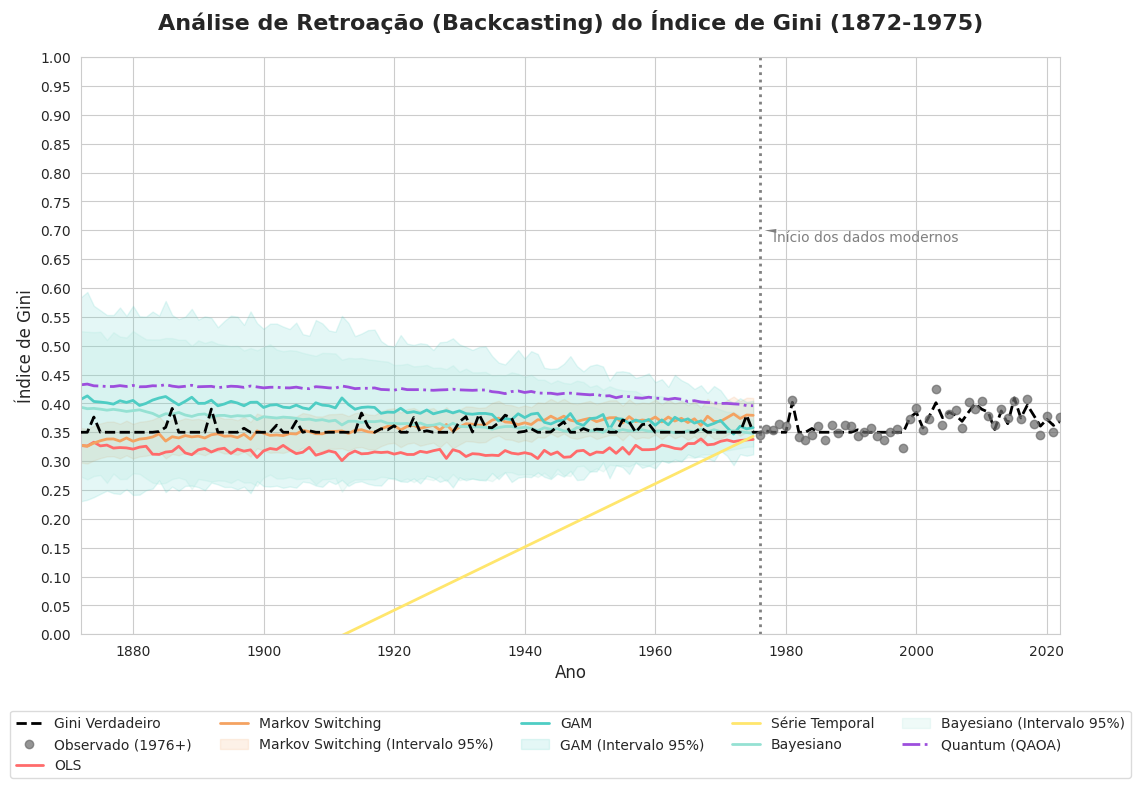

In [15]:
# ===========================
# 9.a VISUALIZAÇÃO (GRÁFICO ESTÁTICO)
# ===========================

print("\nGerando Gráfico Estático (Matplotlib) de Análise de Retroação ...")

# --- Configuração de Estilo (similar ao plotly_white) ---
# Usamos o estilo 'seaborn-whitegrid' para um fundo limpo com grades
sns.set_style("whitegrid")

# Criar a Figura e os Eixos
# Ajustamos o figsize para acomodar o gráfico e a legenda abaixo
fig, ax = plt.subplots(figsize=(12, 8)) 

# Dicionário de estilos de linha (tradução de Plotly para Matplotlib)
line_styles = {
    'solid': '-',
    'dash': '--',
    'dot': ':',
    'dashdot': '-.'
}

# --- Funções auxiliares para Matplotlib ---
# (zorder define a ordem de empilhamento: preenchimento < linhas < marcadores)

def add_model_trace_mpl(ax, df_hist, col_name, color, line_style, label):
    """Adiciona a linha do modelo ao eixo."""
    ax.plot(
        df_hist['Ano'], df_hist[col_name],
        color=color,
        linestyle=line_styles.get(line_style, '-'), # Usa o estilo de linha traduzido
        linewidth=2.0,
        label=label,
        zorder=2 # Linhas ficam acima do preenchimento
    )

def add_fill_trace_mpl(ax, df_hist, low_col, high_col, color, model_name):
    """Adiciona o intervalo de confiança (preenchimento) ao eixo."""
    ax.fill_between(
        df_hist['Ano'], 
        df_hist[low_col], 
        df_hist[high_col],
        color=color,
        alpha=0.15, # Transparência
        label=f'{model_name} (Intervalo 95%)',
        zorder=1 # Preenchimento fica atrás de tudo
    )

# --- Plotagem dos Dados ---

# Gini Verdadeiro
ax.plot(
    df['Ano'], df['Gini_Verdadeiro'],
    color='black',
    linestyle=line_styles['dash'],
    linewidth=2.0,
    label='Gini Verdadeiro',
    zorder=3 # Linha principal fica no topo
)

# Observado (1976+) - Usando 'plot' com 'marker' para melhor controle da legenda
ax.plot(
    df_moderno['Ano'], df_moderno['Gini_Observado'],
    marker='o',             # Marcador circular
    markersize=6,
    markerfacecolor='dimgray',
    markeredgecolor='dimgray',
    linestyle='None',       # Sem linha conectando os pontos
    label='Observado (1976+)',
    alpha=0.7,
    zorder=4 # Marcadores ficam acima de tudo
)

# Linha vertical separando períodos
ax.axvline(
    x=ano_inicio_pnad, 
    color="gray", 
    linestyle=line_styles['dot'], 
    linewidth=2
)
# Anotação para a linha vertical
ax.annotate(
    "Início dos dados modernos",
    xy=(ano_inicio_pnad, 0.7), # Posição (x, y) da seta
    xytext=(ano_inicio_pnad + 2, 0.68), # Posição (x, y) do texto
    arrowprops=dict(facecolor='gray', shrink=0.05, width=1, headwidth=4),
    horizontalalignment='left',
    color='gray'
)

# Adicionar traços dos modelos e seus intervalos
add_model_trace_mpl(ax, df_historico, 'Gini_OLS', cores['OLS'], 'solid', 'OLS')
add_model_trace_mpl(ax, df_historico, 'Gini_Markov', cores['Markov'], 'solid', 'Markov Switching')
add_fill_trace_mpl(ax, df_historico, 'Gini_Markov_Low', 'Gini_Markov_High', cores['Markov'], 'Markov Switching')
add_model_trace_mpl(ax, df_historico, 'Gini_GAM', cores['GAM'], 'solid', 'GAM')
add_fill_trace_mpl(ax, df_historico, 'Gini_GAM_Low', 'Gini_GAM_High', cores['GAM'], 'GAM')
add_model_trace_mpl(ax, df_historico, 'Gini_TimeSeries', cores['TS'], 'solid', 'Série Temporal')
add_model_trace_mpl(ax, df_historico, 'Gini_Bayes_Hierarquico', cores['Bayes'], 'solid', 'Bayesiano')
add_fill_trace_mpl(ax, df_historico, 'Gini_Bayes_Low', 'Gini_Bayes_High', cores['Bayes'], 'Bayesiano') 

if quantum_success:
    add_model_trace_mpl(ax, df_historico, 'Gini_Quantum', cores['Quantum'], 'dashdot', 'Quantum (QAOA)')
elif 'Gini_Quantum' in df_historico.columns: 
    add_model_trace_mpl(ax, df_historico, 'Gini_Quantum', cores['Quantum'], 'dot', 'Quantum (Fallback)')


# ========================================================
# INÍCIO DAS MODIFICAÇÕES DE LAYOUT (Matplotlib)
# ========================================================

# Título
ax.set_title(
    'Análise de Retroação (Backcasting) do Índice de Gini (1872-1975)',
    fontsize=16, 
    fontweight='bold', 
    pad=20 # Espaçamento (similar ao 'pad' do Plotly)
)

# Rótulos dos Eixos
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Índice de Gini', fontsize=12)

# Limites dos Eixos (Ranges)
ax.set_xlim(df['Ano'].min(), df['Ano'].max())
ax.set_ylim(0, 1)

# Ajustar ticks dos eixos (opcional, mas melhora a leitura)
ax.xaxis.set_major_locator(mtick.MultipleLocator(20)) # Ticks a cada 20 anos
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.05)) # Ticks a cada 0.05 no Gini
ax.tick_params(axis='both', which='major', labelsize=10)

# Legenda (posicionada abaixo do gráfico)
# Usamos bbox_to_anchor para mover a legenda para fora da área do gráfico
# loc='upper center' ancora a legenda pelo seu topo central
# bbox_to_anchor=(0.5, -0.1) coloca esse ponto de ancoragem em 50% do eixo X e -10% do eixo Y
leg = ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.12), # Posição abaixo do eixo X
    ncol=5, # Número de colunas para torná-la horizontal
    fontsize=10,
    frameon=True, # Caixa ao redor da legenda
    edgecolor='lightgray',
    facecolor='white'
)

# Ajusta o layout para garantir que a legenda e os títulos não sejam cortados
fig.tight_layout()
# Ajusta o espaço inferior especificamente para a legenda (que está fora do 'tight_layout' padrão)
plt.subplots_adjust(bottom=0.2) 

# ========================================================
# FIM DAS MODIFICAÇÕES DE LAYOUT
# ========================================================

# --- Salva o gráfico estático (JPG com 1200 DPI) ---
# [MODIFICAÇÃO PARA WSL] Caminho para /mnt/c/
output_directory = '/mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes'
# Nome do arquivo modificado para indicar que é do Matplotlib
base_filename = 'grafico_backcasting_estatico_mpl.jpg'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Diretório criado: {output_directory}")
    
save_filename = os.path.join(output_directory, base_filename)

try:
    # Salvando em JPG com 1200 DPI
    # bbox_inches='tight' garante que a legenda (mesmo fora do eixo) seja incluída
    fig.savefig(
        save_filename, 
        format='jpg', 
        dpi=1200, 
        bbox_inches='tight' 
    )
    
    print(f"\n✓ Gráfico estático (Matplotlib) salvo como: {save_filename}")

except Exception as e:
    print(f"\nOcorreu um erro inesperado ao salvar a imagem (Matplotlib): {e}")

# Exibe o gráfico no notebook (opcional)
plt.show()

# Fecha a figura para liberar memória
plt.close(fig)